In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np

from wufam.data.prepare_data import read_kf_data
from wufam.dataset import Dataset
from wufam.metrics.metrics import calc_sharpe

PATH = Path("../data/kf_data")
START = "1970-01-01"
END = "2024-12-31"
DATASET = Dataset.BM_6_M
FACTORS_DATASET = Dataset.FACTORS_M
WEIGHTING = "value_weighted"
FACTOR_ANNUALIZE = 12

## 1.1

In [3]:
portfolios_total_r, portfolios_xs_r, factors_df, rf = read_kf_data(
    portfolios_filename=PATH / DATASET,
    factors_filename=PATH / FACTORS_DATASET,
    start_date=START,
    end_date=END,
    weighting=WEIGHTING,
)

In [4]:
assert portfolios_total_r.shape[0] == portfolios_xs_r.shape[0] == factors_df.shape[0] == rf.shape[0]

## 1.4

In [5]:
from wufam.ap.uncond_factor_model import UncondFactorModel

capm = UncondFactorModel()
capm.fit(
    rets_df=portfolios_xs_r,
    factors_df=factors_df[["Mkt-RF"]],
)

In [6]:
capm.grs_stat, capm.p_value

(np.float64(6.629569676484499), np.float64(8.082971012380241e-07))

Try monthly

In [7]:
ff_model = UncondFactorModel()
ff_model.fit(
    rets_df=portfolios_xs_r,
    factors_df=factors_df,
)

In [8]:
ff_model.grs_stat, ff_model.p_value

(np.float64(5.26895705119617), np.float64(2.5726415393510304e-05))

In [9]:
long_columns = [col for col in portfolios_xs_r.columns if "HiBM" in col]
short_columns = [col for col in portfolios_xs_r.columns if "LoBM" in col]

repl = portfolios_total_r[long_columns].mean(axis=1) - portfolios_total_r[short_columns].mean(
    axis=1
)

In [10]:
np.abs(factors_df["HML"].to_numpy() - repl.round(4).to_numpy()).mean()

np.float64(4.5454545454650823e-07)

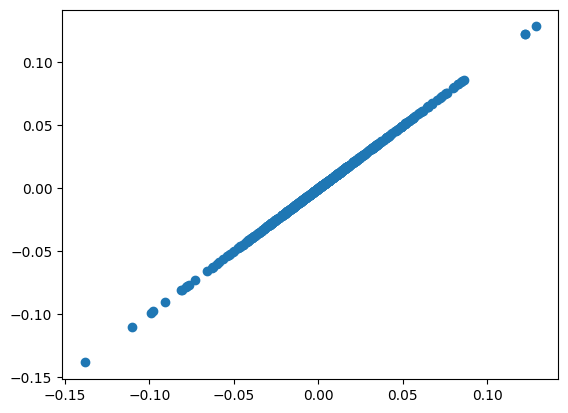

In [11]:
import matplotlib.pyplot as plt

plt.scatter(factors_df["HML"].to_numpy(), repl.round(4).to_numpy());

In [12]:
np.corrcoef(factors_df["HML"].to_numpy(), repl.round(4).to_numpy())

array([[1.        , 0.99999998],
       [0.99999998, 1.        ]])

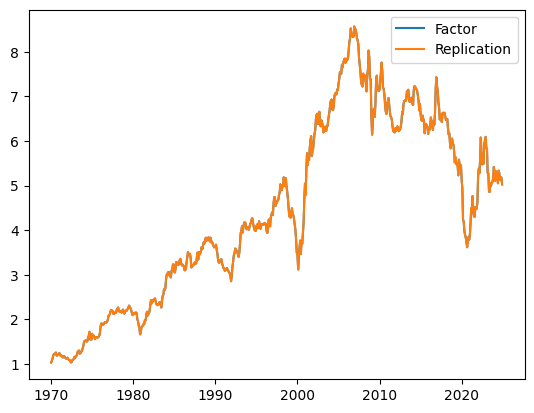

In [13]:
plt.plot(factors_df["HML"].add(1).cumprod(), label="Factor")
plt.plot(repl.round(4).add(1).cumprod(), label="Replication")
plt.legend()
plt.show()